## Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import pickle
from sklearn.linear_model import LogisticRegression 

import matplotlib.pyplot as plt
import matplotlib.axes as axs
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression

## Data Preparation

In [2]:
# load data
df_purchase = pd.read_csv('purchase data.csv')

# load pre trained scaler, pca and k-means to segment new data
scaler = pickle.load(open('scaler.pickle', 'rb'))
pca = pickle.load(open('pca.pickle', 'rb'))
kmeans_pca = pickle.load(open('pca_kmeans.pickle', 'rb'))

# standardization
features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
df_purchase_segm_std = scaler.transform(features)
# apply PCA
df_purchase_segm_pca = pca.transform(df_purchase_segm_std)
# segment data
purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)

# create a copy of the data frame
df_purchase_predictors = df_purchase.copy()
# add segment labels
df_purchase_predictors['Segment'] = purchase_segm_kmeans_pca
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, prefix = 'Segment', prefix_sep = '_')
df_purchase_predictors = pd.concat([df_purchase_predictors, segment_dummies], axis = 1)

df_pa = df_purchase_predictors

## Purchase Probability Model

In [3]:
# In order to predict we need input and output variables. 
# Our Y is Incidence, as we want to predict the purchase probability for our customers
Y = df_pa['Incidence']

In [4]:
# Our dependant variable is based on the average price of chocolate candy bars. 
# Therefore, X is a data frame, containing the mean across the five prices.
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] +
                   df_pa['Price_2'] +
                   df_pa['Price_3'] +
                   df_pa['Price_4'] +
                   df_pa['Price_5'] ) / 5

In [5]:
# We create a Logistic Regression model using sk learn. Then we fit the model with our X or price and our Y or incidence.
model_purchase = LogisticRegression(solver = 'sag')
model_purchase.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [6]:
# The coefficients for price. It is negative, signaling that with an increase in price, the purchase probability decreases.
model_purchase.coef_

array([[-2.34830743]])

## Price Elasticity of Purchase Probability

Here we see the prices for the five different brands, which is an important factor in determining purchase probability. <br>
It informs the price range, for which we will be exploring purchase probability.

In [7]:
df_pa[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


In [8]:
# price range for which we'll examine the purchase probability : we choose a price range between 0.5 and 3.49,
# which expands the observed price range
price_range = np.arange(0.5, 3.5, 0.01)

In [9]:
df_price_range = pd.DataFrame(price_range)

In [10]:
# predict purchase probability for our newly defined price range. Using it to calculate price elasticities
Y_pr = model_purchase.predict_proba(df_price_range)
purchase_pr = Y_pr[:][:, 1]
pe = model_purchase.coef_[:, 0] * price_range * (1 - purchase_pr)

In [11]:
# create price elasticities master data frame.
# will contain all the elasticities we calculate during the purchase analytics
df_price_elasticities = pd.DataFrame(price_range)

In [12]:
df_price_elasticities = df_price_elasticities.rename(columns = {0: "Price_Point"})
df_price_elasticities['Mean_PE'] = pe
df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096430
1,0.51,-0.100500
2,0.52,-0.104697
3,0.53,-0.109024
4,0.54,-0.113484
...,...,...
295,3.45,-8.013848
296,3.46,-8.039099
297,3.47,-8.064316
298,3.48,-8.089498


In [13]:
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096430
1,0.51,-0.100500
2,0.52,-0.104697
3,0.53,-0.109024
4,0.54,-0.113484
5,0.55,-0.118081
6,0.56,-0.122818
7,0.57,-0.127698
8,0.58,-0.132725
9,0.59,-0.137902


Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

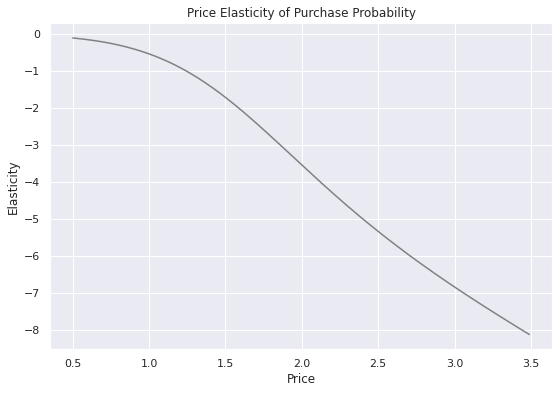

In [14]:
# We display the price elasticity of purchase probability of the average customer.
# We observe that the price elasticities are all negative. Furthermore we can spot where the customer becomes inelastic.
# But to find the precise spot we can consult the price elasticities data frame.
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

## Purchase Probability by Segments

### $\color{green}{\text{Segment 1 - Career-Focused}}$

In [15]:
# We filter the data to contain only customers from segment 1, the career-focused.
df_pa_segment_1 = df_pa[df_pa['Segment'] == 1]

In [16]:
# Again we want to predict the purchase probability, so our Y variable is the incidence column.
# Only here we select only the customers from the first segment.
Y = df_pa_segment_1['Incidence']

In [17]:
X = pd.DataFrame()

In [18]:
# We calculate the average price for purchases in segment 1.
X['Mean_Price'] = (df_pa_segment_1['Price_1'] + 
                   df_pa_segment_1['Price_2'] + 
                   df_pa_segment_1['Price_3'] + 
                   df_pa_segment_1['Price_4'] + 
                   df_pa_segment_1['Price_5']) / 5

In [19]:
# Fit logistic regression model
model_incidence_segment_1 = LogisticRegression(solver = 'sag')
model_incidence_segment_1.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
# We observe that the price coefficient for the career focused is -1.7, whereas for the average customer it was -2.35.
# This is an indicator, that this segment is less price sensitive compared to the average customer.
model_incidence_segment_1.coef_

array([[-1.65236644]])

In [21]:
# Calculate Price Elasticity of the career-focused segment.
Y_segment_1 = model_incidence_segment_1.predict_proba(df_price_range)
purchase_pr_segment_1 = Y_segment_1[:][:, 1]
pe_segment_1 = model_incidence_segment_1.coef_[:, 0] * price_range * (1 - purchase_pr_segment_1)

### Results

In [22]:
df_price_elasticities['PE_Segment_1'] = pe_segment_1

Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

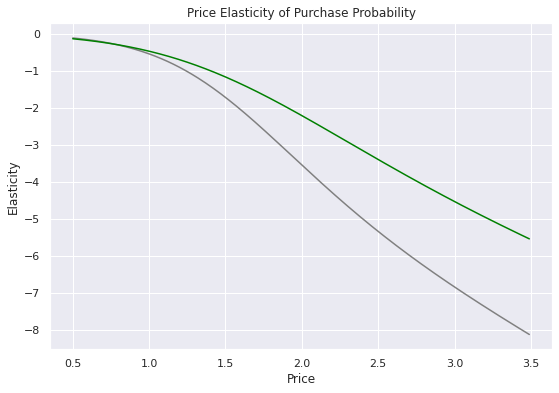

In [23]:
# We plot the elasticities of the average customer and the career-focused segment side by side. 
# The career-focused segment is displayed in green. The same color we used during the descriptive analysis.
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

### $\color{red}{\text{Segment 2 - Fewer-Opportunities}}$

In [24]:
# Select only customers from segment 2, the fewer-opportunities.
df_pa_segment_2 = df_pa[df_pa['Segment'] == 2]

In [25]:
# Logistic regression model
Y = df_pa_segment_2['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_2['Price_1'] + 
                   df_pa_segment_2['Price_2'] + 
                   df_pa_segment_2['Price_3'] + 
                   df_pa_segment_2['Price_4'] + 
                   df_pa_segment_2['Price_5']) / 5

model_incidence_segment2 = LogisticRegression(solver = 'sag')
model_incidence_segment2.fit(X, Y)

# Calculate price elasticities
model_incidence_segment2.coef_
Y_segment_2 = model_incidence_segment2.predict_proba(df_price_range)
purchase_pr_segment2 = Y_segment_2[:][: , 1]
pe_segment2 = model_incidence_segment2.coef_[:,0] * price_range * ( 1- purchase_pr_segment2)

### Results

In [26]:
df_price_elasticities['PE_Segment_2'] = pe_segment2

Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

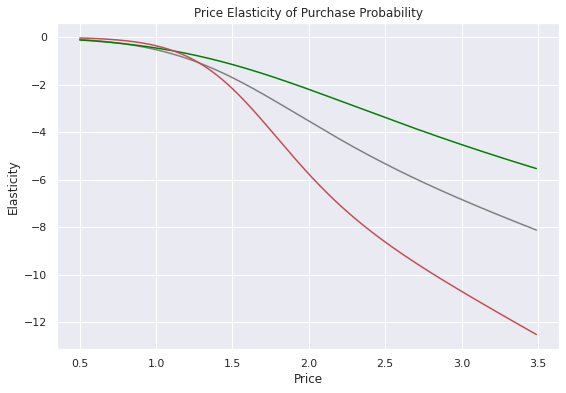

In [27]:
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.plot(price_range, pe_segment2, color = 'r')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

### $\color{blue}{\text{Segment 0 - Well-Off}}$

In [28]:
# Select only customers from segment 0, the Well-Off segment.
df_pa_segment_0 = df_pa[df_pa['Segment'] == 0]
# Prepare dependant and independant variables.
Y = df_pa_segment_0['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_0['Price_1'] + 
                   df_pa_segment_0['Price_2'] + 
                   df_pa_segment_0['Price_3'] + 
                   df_pa_segment_0['Price_4'] + 
                   df_pa_segment_0['Price_5']) / 5
# Logistic regression model
model_incidence_segment0 = LogisticRegression(solver = 'sag')
model_incidence_segment0.fit(X, Y)

model_incidence_segment0.coef_
Y_segment_0 = model_incidence_segment0.predict_proba(df_price_range)
purchase_pr_segment0 = Y_segment_0[:][: , 1]
pe_segment0 = model_incidence_segment0.coef_[:,0] * price_range *( 1- purchase_pr_segment0)
df_price_elasticities.insert(2, column = 'PE_Segment_0', value = pe_segment0)

### $\color{orange}{\text{Segment 3 - Standard}}$

In [29]:
# Select only customers from segment 3 
df_pa_segment_3 = df_pa[df_pa['Segment'] == 3]
# Prepare dependant and independant variables.
Y = df_pa_segment_3['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_3['Price_1'] + 
                   df_pa_segment_3['Price_2'] + 
                   df_pa_segment_3['Price_3'] + 
                   df_pa_segment_3['Price_4'] + 
                   df_pa_segment_3['Price_5']) / 5
# Logistic regression model
model_incidence_segment3 = LogisticRegression(solver = 'sag')
model_incidence_segment3.fit(X, Y)

model_incidence_segment3.coef_
Y_segment_3 = model_incidence_segment2.predict_proba(df_price_range)
purchase_pr_segment3 = Y_segment_3[:][: , 1]
pe_segment3 = model_incidence_segment3.coef_[:,0] * price_range *( 1- purchase_pr_segment3)
df_price_elasticities['PE_Segment_3'] = pe_segment3
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3
0,0.50,-0.096430,-0.168099,-0.117631,-0.032816,-0.013798
1,0.51,-0.100500,-0.173025,-0.121694,-0.034673,-0.014579
2,0.52,-0.104697,-0.178021,-0.125844,-0.036619,-0.015397
3,0.53,-0.109024,-0.183088,-0.130084,-0.038659,-0.016255
4,0.54,-0.113484,-0.188227,-0.134414,-0.040798,-0.017154
5,0.55,-0.118081,-0.193437,-0.138836,-0.043039,-0.018096
6,0.56,-0.122818,-0.198719,-0.143350,-0.045386,-0.019083
7,0.57,-0.127698,-0.204075,-0.147959,-0.047845,-0.020117
8,0.58,-0.132725,-0.209503,-0.152664,-0.050420,-0.021200
9,0.59,-0.137902,-0.215005,-0.157465,-0.053117,-0.022334


### ${\textbf{Results}}$

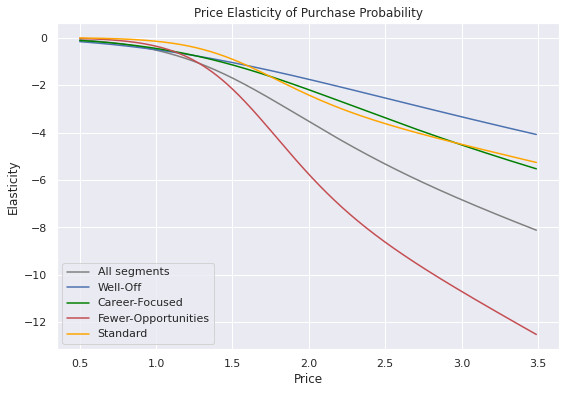

In [30]:
# We display all elasticities of purchase probability on the same plot. 

plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment0, color = 'b')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.plot(price_range, pe_segment2, color = 'r')
plt.plot(price_range, pe_segment3, color = 'orange')
plt.legend(('All segments', 'Well-Off', 'Career-Focused', 'Fewer-Opportunities', 'Standard'))
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability');

We observe that the Well-Off and Career-focused segment are the least elastic when compared to the rest. 
So, their purchase probability elasticity is not as affected by price.
The price elasticities for the Standard segment seem to differ across price range. This may be due to the fact that
the standard segment is least homogenous, which we discovered during our descriptive analysis. 
It may be that the customers in this segment have different shopping habbits, which is why their 
customers start with being more elastic than average but then shift to being more inelastic than the average customer
and indeed the Career-focused segment.

## Purchase Probability with Promotion Feature

### Data Preparation

In [31]:
Y = df_pa['Incidence']

In [32]:
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] + 
                   df_pa['Price_2'] + 
                   df_pa['Price_3'] + 
                   df_pa['Price_4'] + 
                   df_pa['Price_5']) / 5

In [33]:
# We include a second promotion feature. We'd like to examine the effects of promotions on purchase probability :
# calculate the average promotion rate across the five brands. We add the mean price for the brands.
X['Mean_Promotion'] = (df_pa['Promotion_1'] +
                       df_pa['Promotion_2'] +
                       df_pa['Promotion_3'] +
                       df_pa['Promotion_4'] +
                       df_pa['Promotion_5'] ) / 5
X.head()

,Mean_Price,Mean_Promotion
0,2.044,0.2
1,2.028,0.0
2,2.028,0.0
3,2.028,0.0
4,2.030,0.0


## Model Estimation

In [34]:
# The coefficient for promotion is positive. 
# Therefore, there is a positive relationship between promotion and purchase probability.
model_incidence_promotion = LogisticRegression(solver = 'sag')
model_incidence_promotion.fit(X, Y)
model_incidence_promotion.coef_

array([[-1.49390605,  0.56158863]])

## Price Elasticity with Promotion

In [35]:
# We create a data frame on which our model will predict. We need to include A price and promotion feature.
# First, we'll include the price range as the price feature. Next, we'll include the promotion feature.
df_price_elasticity_promotion = pd.DataFrame(price_range)
df_price_elasticity_promotion = df_price_elasticity_promotion.rename(columns = {0: "Price_Range"})

In [36]:
# We'll calculate price elasticities of purchase probability when we assume there is a promotion across at each price points.
df_price_elasticity_promotion['Promotion'] = 1

In [37]:
# Purchase Probability with Promotion Model Prediction
Y_promotion = model_incidence_promotion.predict_proba(df_price_elasticity_promotion)

In [38]:
promo = Y_promotion[:, 1]
price_elasticity_promo = (model_incidence_promotion.coef_[:, 0] * price_range) * (1 - promo)

In [39]:
# Update master data to include elasticities of purchase probability with promotion feature
df_price_elasticities['Elasticity_Promotion_1'] = price_elasticity_promo
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1
0,0.50,-0.096430,-0.168099,-0.117631,-0.032816,-0.013798,-0.125724
1,0.51,-0.100500,-0.173025,-0.121694,-0.034673,-0.014579,-0.129839
2,0.52,-0.104697,-0.178021,-0.125844,-0.036619,-0.015397,-0.134034
3,0.53,-0.109024,-0.183088,-0.130084,-0.038659,-0.016255,-0.138309
4,0.54,-0.113484,-0.188227,-0.134414,-0.040798,-0.017154,-0.142664
5,0.55,-0.118081,-0.193437,-0.138836,-0.043039,-0.018096,-0.147101
6,0.56,-0.122818,-0.198719,-0.143350,-0.045386,-0.019083,-0.151622
7,0.57,-0.127698,-0.204075,-0.147959,-0.047845,-0.020117,-0.156226
8,0.58,-0.132725,-0.209503,-0.152664,-0.050420,-0.021200,-0.160915
9,0.59,-0.137902,-0.215005,-0.157465,-0.053117,-0.022334,-0.165690


## Price Elasticity without Promotion

In [40]:
df_price_elasticity_promotion_no = pd.DataFrame(price_range)
df_price_elasticity_promotion_no = df_price_elasticity_promotion_no.rename(columns = {0: "Price_Range"})

In [41]:
# Promotion feature -No Promotion.
# We assume there aren't any promotional activities on any of the price points.
# We examine the elasticity of purchase probability when there isn't promotion.
df_price_elasticity_promotion_no['Promotion'] = 0

In [42]:
#Purchase Probability without Promotion Model Prediction
Y_no_promo = model_incidence_promotion.predict_proba(df_price_elasticity_promotion_no)

In [43]:
no_promo = Y_no_promo[: , 1]

In [44]:
price_elasticity_no_promo = model_incidence_promotion.coef_[:, 0] * price_range *(1- no_promo)

In [45]:
# Update master data frame to include purchase probability elasticities without promotion.
# We can now see the values with and without promotion and compare them for each price point in our price range.
df_price_elasticities['Elasticity_Promotion_0'] = price_elasticity_no_promo

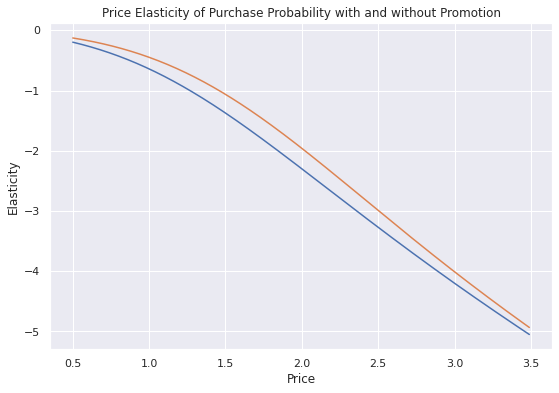

In [46]:
# Plot purchase elasticities with and without promotion side by side for comprarisson.
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_no_promo)
plt.plot(price_range, price_elasticity_promo)
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability with and without Promotion');

Here we observe that the purchase probability elasticity of the customer is less elastic when there is promotion.
This is an important insight for marketers, as according to our model people are more likely to buy a product if there is some promotional activity rather than purchase a product with the same price, when it isn't on promotion. 

## ${\textbf{Brand Choice}}$

### Data Preparation

In [47]:
# Here we are interested in determining the brand choice of the customer. 
# Hence, we filter our data, to include only purchase occasion, when a purchase has occured. 
brand_choice = df_pa[df_pa['Incidence'] == 1]
brand_choice.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,...,47,1,110866,1,0,2,0,0,1,0
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,...,47,1,110866,1,0,2,0,0,1,0
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,...,47,1,110866,1,0,2,0,0,1,0
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,...,47,1,110866,1,0,2,0,0,1,0
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,...,47,1,110866,1,0,2,0,0,1,0


In [48]:
# Our model will predict the chosen brand.
Y = brand_choice['Brand']

In [49]:
# a recap of the existing feature
# we will not use the features already used in our segmentation model, same for the promotion features
brand_choice.columns.values

array(['ID', 'Day', 'Incidence', 'Brand', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3',
       'Promotion_4', 'Promotion_5', 'Sex', 'Marital status', 'Age',
       'Education', 'Income', 'Occupation', 'Settlement size', 'Segment',
       'Segment_0', 'Segment_1', 'Segment_2', 'Segment_3'], dtype=object)

In [50]:
# we predict based on the prices for the five brands.
features = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
X = brand_choice[features]

In [51]:
# general brand Choice Model fit.
model_brand_choice = LogisticRegression(solver = 'sag', multi_class = 'multinomial')
model_brand_choice.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
# making some transformations on the coefficients data frame to increase readability.
# transposing the data frame, to keep with the conventional representation of results.
bc_coef = pd.DataFrame(np.transpose(model_brand_choice.coef_))
bc_coef.columns = ['Coef_Brand_1', 'Coef_Brand_2', 'Coef_Brand_3', 'Coef_Brand_4', 'Coef_Brand_5']
prices = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.92,1.27,1.62,0.57,0.44
Price_2,0.66,-1.88,0.56,0.40,0.26
Price_3,2.42,-0.21,0.50,-1.40,-1.31
Price_4,0.70,-0.21,1.04,-1.25,-0.29
Price_5,-0.20,0.59,0.45,0.25,-1.09


## Own Price Elasticity Brand 5

In [53]:
# We want to calculate price elasticity of brand choice.
# to do so we create a data frame with price columns, which our model will use to predict the brand choice probabilities.
df_own_brand_5 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5['Price_1'] = brand_choice['Price_1'].mean()
df_own_brand_5['Price_2'] = brand_choice['Price_2'].mean()
df_own_brand_5['Price_3'] = brand_choice['Price_3'].mean()
df_own_brand_5['Price_4'] = brand_choice['Price_4'].mean()
df_own_brand_5['Price_5'] = price_range
df_own_brand_5

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,2.159658,0.50
1,1.384559,1.764717,2.006694,2.159658,0.51
2,1.384559,1.764717,2.006694,2.159658,0.52
3,1.384559,1.764717,2.006694,2.159658,0.53
4,1.384559,1.764717,2.006694,2.159658,0.54
5,1.384559,1.764717,2.006694,2.159658,0.55
6,1.384559,1.764717,2.006694,2.159658,0.56
7,1.384559,1.764717,2.006694,2.159658,0.57
8,1.384559,1.764717,2.006694,2.159658,0.58
9,1.384559,1.764717,2.006694,2.159658,0.59


In [54]:
# Brand Choice Model prediction.
predict_brand_5 = model_brand_choice.predict_proba(df_own_brand_5)

In [55]:
# Our model returns the probabilities of choosing each of the 5 brands. 
# Since, we are interested in the probability for the fifth brand we need to obtain the last column located on position 4,
# as we're starting to count from 0.
pr_own_brand_5 = predict_brand_5[: ][:, 4]

In [56]:
# We're interested in choosing brand 5. 
# Therefore, the beta coefficient we require is that of the brand 5 coefficient and price 5.
beta5 = bc_coef.iloc[4, 4]
beta5

-1.09

In [57]:
# Calculating price elasticities for brand choice without promotion. 
own_price_elasticity_brand_5 = beta5 * price_range * (1 - pr_own_brand_5)

In [58]:
# Adding the price elasticities to our master data frame. 
df_price_elasticities['Brand_5'] = own_price_elasticity_brand_5
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5
0,0.50,-0.096430,-0.168099,-0.117631,-0.032816,-0.013798,-0.125724,-0.195640,-0.049055
1,0.51,-0.100500,-0.173025,-0.121694,-0.034673,-0.014579,-0.129839,-0.201761,-0.050616
2,0.52,-0.104697,-0.178021,-0.125844,-0.036619,-0.015397,-0.134034,-0.207984,-0.052207
3,0.53,-0.109024,-0.183088,-0.130084,-0.038659,-0.016255,-0.138309,-0.214311,-0.053827
4,0.54,-0.113484,-0.188227,-0.134414,-0.040798,-0.017154,-0.142664,-0.220742,-0.055477
5,0.55,-0.118081,-0.193437,-0.138836,-0.043039,-0.018096,-0.147101,-0.227278,-0.057158
6,0.56,-0.122818,-0.198719,-0.143350,-0.045386,-0.019083,-0.151622,-0.233919,-0.058871
7,0.57,-0.127698,-0.204075,-0.147959,-0.047845,-0.020117,-0.156226,-0.240667,-0.060614
8,0.58,-0.132725,-0.209503,-0.152664,-0.050420,-0.021200,-0.160915,-0.247522,-0.062391
9,0.59,-0.137902,-0.215005,-0.157465,-0.053117,-0.022334,-0.165690,-0.254485,-0.064199


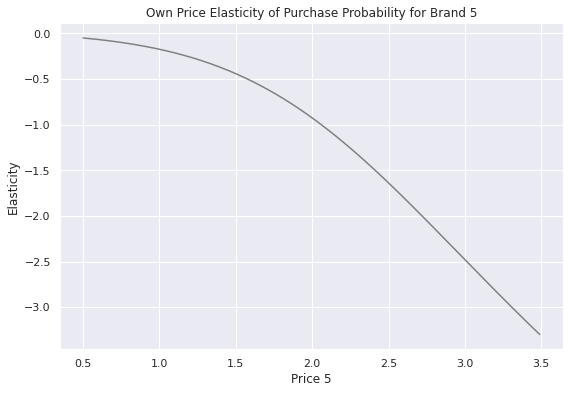

In [59]:
# Plot elasticities of purchase probability for brand 5.
plt.figure(figsize = (9, 6))
plt.plot(price_range, own_price_elasticity_brand_5, color = 'grey')
plt.xlabel('Price 5')
plt.ylabel('Elasticity')
plt.title('Own Price Elasticity of Purchase Probability for Brand 5');

## Cross Price Elasticity Brand 5, Cross Brand 4

In [60]:
# We want to examine the effect of the changes in price of a competitor brand.
# the brand which comes closest to brand 5 is brand 4.
df_brand5_cross_brand4 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4['Price_1'] = brand_choice['Price_1'].mean()
df_brand5_cross_brand4['Price_2'] = brand_choice['Price_2'].mean()
df_brand5_cross_brand4['Price_3'] = brand_choice['Price_3'].mean()
df_brand5_cross_brand4['Price_4'] = price_range
df_brand5_cross_brand4['Price_5'] = brand_choice['Price_5'].mean()

In [61]:
df_brand5_cross_brand4.head()

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,0.50,2.654296
1,1.384559,1.764717,2.006694,0.51,2.654296
2,1.384559,1.764717,2.006694,0.52,2.654296
3,1.384559,1.764717,2.006694,0.53,2.654296
4,1.384559,1.764717,2.006694,0.54,2.654296


In [62]:
predict_brand5_cross_brand4 = model_brand_choice.predict_proba(df_brand5_cross_brand4)

In [63]:
# As now we're interested in what the probability of choosing the competitor brand is, 
# we need to select the purchase probability for brand 4, contained in the 4th column with index 3. 
pr_brand_4 = predict_brand5_cross_brand4[:][:, 3]

In [64]:
beta5

-1.09

In [65]:
# In order to calculate the cross brand price elasticity, we need to use the new formula we introduced in the lecture.
# The elasticity is equal to negative the price coefficient of the own brand multiplied by the price of the cross brand,
# further multiplied by the probability for choosing the cross brand.
brand5_cross_brand4_price_elasticity = -beta5 * price_range * pr_brand_4

In [66]:
# Update price elasticities data frame to include the cross price elasticities for brand 5 with respect to brand 4.
df_price_elasticities['Brand_5_Cross_Brand_4'] = brand5_cross_brand4_price_elasticity
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4
0,0.50,-0.096430,-0.168099,-0.117631,-0.032816,-0.013798,-0.125724,-0.195640,-0.049055,0.332011
1,0.51,-0.100500,-0.173025,-0.121694,-0.034673,-0.014579,-0.129839,-0.201761,-0.050616,0.337288
2,0.52,-0.104697,-0.178021,-0.125844,-0.036619,-0.015397,-0.134034,-0.207984,-0.052207,0.342507
3,0.53,-0.109024,-0.183088,-0.130084,-0.038659,-0.016255,-0.138309,-0.214311,-0.053827,0.347669
4,0.54,-0.113484,-0.188227,-0.134414,-0.040798,-0.017154,-0.142664,-0.220742,-0.055477,0.352773
5,0.55,-0.118081,-0.193437,-0.138836,-0.043039,-0.018096,-0.147101,-0.227278,-0.057158,0.357820
6,0.56,-0.122818,-0.198719,-0.143350,-0.045386,-0.019083,-0.151622,-0.233919,-0.058871,0.362809
7,0.57,-0.127698,-0.204075,-0.147959,-0.047845,-0.020117,-0.156226,-0.240667,-0.060614,0.367741
8,0.58,-0.132725,-0.209503,-0.152664,-0.050420,-0.021200,-0.160915,-0.247522,-0.062391,0.372614
9,0.59,-0.137902,-0.215005,-0.157465,-0.053117,-0.022334,-0.165690,-0.254485,-0.064199,0.377430


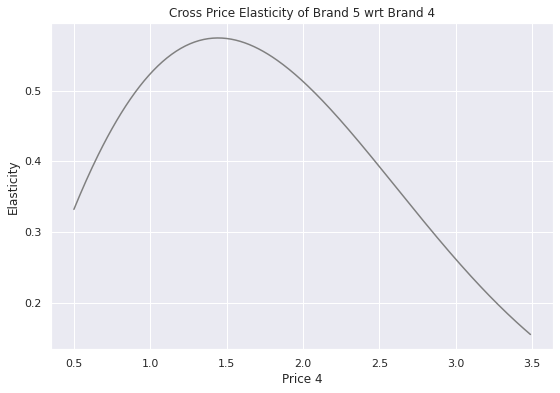

In [67]:
# Here we examine the cross price elasticity of purchase probability for brand 5 with respect to brand 4.
# We observe they are positive. As the price of the competitor brand increases, 
# so does the probability for purchasing our own brand.
# Even though the elasticity starts to decrease from the 1.45 mark, it is still positive, 
# signalling that the increase in purchase probability for the own brand happens more slowly.
plt.figure(figsize = (9, 6))
plt.plot(price_range, brand5_cross_brand4_price_elasticity, color = 'grey')
plt.xlabel('Price 4')
plt.ylabel('Elasticity')
plt.title('Cross Price Elasticity of Brand 5 wrt Brand 4');

## Own and Cross-Price Elasticity by Segment

### $\color{orange}{\text{Well-Off}}$

In [68]:
# We are interested in analysing the purchase probability for choosing brand 5 by segments.
# we filter our data to contain only purchase incidences of the third segment - Well-off.
# otherwise, the workflow is the same
brand_choice_s3 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s3 = brand_choice_s3[brand_choice_s3['Segment'] == 0]
brand_choice_s3.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
101,200000002,6,1,4,1,0,0,1.59,1.87,2.01,...,52,2,159052,2,1,0,1,0,0,0
115,200000002,100,1,4,2,0,0,1.47,1.90,1.95,...,52,2,159052,2,1,0,1,0,0,0
138,200000002,283,1,4,3,0,0,1.37,1.89,2.00,...,52,2,159052,2,1,0,1,0,0,0
141,200000002,307,1,4,1,0,0,1.34,1.89,2.01,...,52,2,159052,2,1,0,1,0,0,0
153,200000002,422,1,4,1,0,0,1.34,1.89,2.02,...,52,2,159052,2,1,0,1,0,0,0


In [69]:
# Brand Choice Model estimation.
Y = brand_choice_s3['Brand']
brand_choice_s3 = pd.get_dummies(brand_choice_s3, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s3[features]
model_brand_choice_s3 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s3.fit(X, Y)

# Coefficients table for segment 3
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s3.coef_))
coefficients = ['Coef_Brand_1', 'Coef_Brand_2', 'Coef_Brand_3', 'Coef_Brand_4', 'Coef_Brand_5']
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-2.15,1.33,0.82,0.12,-0.11
Price_2,-0.96,-1.38,1.29,0.78,0.27
Price_3,2.01,-1.65,-0.49,0.03,0.11
Price_4,2.52,0.96,-0.25,-1.90,-1.33
Price_5,-0.99,-0.30,1.17,0.56,-0.44


### $\color{orange}{\text{Own-Brand Price Elasticity}}$

In [70]:
# Calculating own-brand price elasticity for brand 5 and the Well-off segment.
df_own_brand_5_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_own_brand_5_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_own_brand_5_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_own_brand_5_s3['Price_4'] = brand_choice_s3['Price_4'].mean()
df_own_brand_5_s3['Price_5'] = price_range

predict_own_brand_5_s3 = model_brand_choice_s3.predict_proba(df_own_brand_5_s3)
pr_own_brand_5_s3 = predict_own_brand_5_s3[: ][: , 4]

own_price_elasticity_brand_5_s3 =  beta5 * price_range * (1 - pr_own_brand_5_s3)
df_price_elasticities['Brand 5 S3'] = own_price_elasticity_brand_5_s3

### $\color{orange}{\text{Cross-Brand Price Elasticity}}$

In [71]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Well-off segment.
df_brand5_cross_brand4_s3 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_brand5_cross_brand4_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_brand5_cross_brand4_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_brand5_cross_brand4_s3['Price_4'] = price_range
df_brand5_cross_brand4_s3['Price_5'] = brand_choice_s3['Price_5'].mean()

predict_brand5_cross_brand4_s3 = model_brand_choice_s3.predict_proba(df_brand5_cross_brand4_s3)
pr_cross_brand_5_s3 = predict_brand5_cross_brand4_s3[: ][: , 3]

# Update master data frame to include the newly obtained cross-brand price elasticities.
brand5_cross_brand4_price_elasticity_s3 = -beta5 * price_range * pr_cross_brand_5_s3
df_price_elasticities['Brand_5_Cross_Brand_4_S3'] = brand5_cross_brand4_price_elasticity_s3
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S3,Brand_5_Cross_Brand_4_S3
0,0.50,-0.096430,-0.168099,-0.117631,-0.032816,-0.013798,-0.125724,-0.195640,-0.049055,0.332011,-0.297320,0.482421
1,0.51,-0.100500,-0.173025,-0.121694,-0.034673,-0.014579,-0.129839,-0.201761,-0.050616,0.337288,-0.303366,0.491726
2,0.52,-0.104697,-0.178021,-0.125844,-0.036619,-0.015397,-0.134034,-0.207984,-0.052207,0.342507,-0.309422,0.501016
3,0.53,-0.109024,-0.183088,-0.130084,-0.038659,-0.016255,-0.138309,-0.214311,-0.053827,0.347669,-0.315489,0.510290
4,0.54,-0.113484,-0.188227,-0.134414,-0.040798,-0.017154,-0.142664,-0.220742,-0.055477,0.352773,-0.321567,0.519548
5,0.55,-0.118081,-0.193437,-0.138836,-0.043039,-0.018096,-0.147101,-0.227278,-0.057158,0.357820,-0.327657,0.528790
6,0.56,-0.122818,-0.198719,-0.143350,-0.045386,-0.019083,-0.151622,-0.233919,-0.058871,0.362809,-0.333758,0.538016
7,0.57,-0.127698,-0.204075,-0.147959,-0.047845,-0.020117,-0.156226,-0.240667,-0.060614,0.367741,-0.339872,0.547227
8,0.58,-0.132725,-0.209503,-0.152664,-0.050420,-0.021200,-0.160915,-0.247522,-0.062391,0.372614,-0.345998,0.556420
9,0.59,-0.137902,-0.215005,-0.157465,-0.053117,-0.022334,-0.165690,-0.254485,-0.064199,0.377430,-0.352137,0.565597


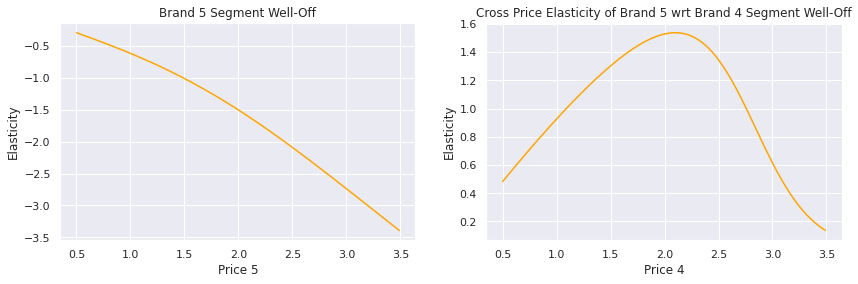

In [72]:
# Using a figure with axes we plot the own brand and cross-brand price elasticities for brand 5 cross brand 4 side by side.
fig, axs = plt.subplots(1, 2, figsize = (14, 4))
axs[0].plot(price_range, own_price_elasticity_brand_5_s3, color = 'orange')
axs[0].set_title('Brand 5 Segment Well-Off')
axs[0].set_xlabel('Price 5')

axs[1].plot(price_range, brand5_cross_brand4_price_elasticity_s3, color = 'orange')
axs[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Well-Off')
axs[1].set_xlabel('Price 4')

for ax in axs.flat:
    ax.set(ylabel = 'Elasticity')

### $\color{blue}{\text{Standard}}$

In [73]:
# Here we are interesting in analysing the brand choice probability of the Standard segment.
# We filter our data, by selecting only purchases from segment 0.
brand_choice_s0 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s0 = brand_choice_s0[brand_choice_s0['Segment'] == 3]
brand_choice_s0.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
2398,200000024,44,1,2,2,0,0,1.35,1.58,1.97,...,32,1,88428,0,0,3,0,0,0,1
2403,200000024,98,1,2,2,0,0,1.47,1.90,1.95,...,32,1,88428,0,0,3,0,0,0,1
2408,200000024,143,1,2,3,0,0,1.21,1.35,1.99,...,32,1,88428,0,0,3,0,0,0,1
2410,200000024,162,1,2,5,0,0,1.39,1.90,1.94,...,32,1,88428,0,0,3,0,0,0,1
2417,200000024,217,1,5,1,0,0,1.34,1.89,1.99,...,32,1,88428,0,0,3,0,0,0,1


In [74]:
# Brand Choice Model estimation.
Y = brand_choice_s0['Brand']
brand_choice_s0 = pd.get_dummies(brand_choice_s0, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s0[features]
model_brand_choice_s0 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 200)
model_brand_choice_s0.fit(X, Y)

# Coefficients table segment 0.
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s0.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

/home/quentin/.local/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### $\color{blue}{\text{Own-Brand Price Elasticity}}$

In [75]:
# Calculating own-brand price elasticity for brand 5 and the Standard segment.
df_own_brand_5_s0 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s0['Price_1'] = brand_choice_s0['Price_1'].mean()
df_own_brand_5_s0['Price_2'] = brand_choice_s0['Price_2'].mean()
df_own_brand_5_s0['Price_3'] = brand_choice_s0['Price_3'].mean()
df_own_brand_5_s0['Price_4'] = brand_choice_s0['Price_4'].mean()
df_own_brand_5_s0['Price_5'] = price_range

predict_own_brand_5_s0 = model_brand_choice_s0.predict_proba(df_own_brand_5_s0)
pr_own_brand_5_s0 = predict_own_brand_5_s0[: ][: , 4]

# Compute price elasticities and update master data frame.
# We'd like to include the elasticities for the segments in order from 0 to three, which is why we use insert() on position 10.
own_price_elasticity_brand_5_s0 =  beta5 * price_range * (1 - pr_own_brand_5_s0)
df_price_elasticities.insert(10, column = 'Brand 5 S0', value = own_price_elasticity_brand_5_s0)

### $\color{blue}{\text{Cross-Brand Price Elasticity}}$

In [76]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Standard segment.
df_brand5_cross_brand4_s0 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s0['Price_1'] = brand_choice_s0['Price_1'].mean()
df_brand5_cross_brand4_s0['Price_2'] = brand_choice_s0['Price_2'].mean()
df_brand5_cross_brand4_s0['Price_3'] = brand_choice_s0['Price_3'].mean()
df_brand5_cross_brand4_s0['Price_4'] = price_range
df_brand5_cross_brand4_s0['Price_5'] = brand_choice_s0['Price_5'].mean()

predict_brand5_cross_brand4_s0 = model_brand_choice_s0.predict_proba(df_brand5_cross_brand4_s0)
pr_cross_brand_5_s0 = predict_brand5_cross_brand4_s0[: ][: , 3]

# Compute price elasticities and update master data frame.
# We need to use insert() on position 11, to save the price elasticities in the correct order.
brand5_cross_brand4_price_elasticity_s0 = -beta5 * price_range * pr_cross_brand_5_s0
df_price_elasticities.insert(11, column = 'Brand_5_Cross_Brand_4_S0', value = brand5_cross_brand4_price_elasticity_s0)

### $\color{green}{\text{Career-Focused}}$

In [77]:
# Filter data by the Career-focused segment, which is the first segment.
brand_choice_s1 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s1 = brand_choice_s1[brand_choice_s1['Segment'] == 1]

In [78]:
# Brand Choice Model estimation.
Y = brand_choice_s1['Brand']
brand_choice_s1 = pd.get_dummies(brand_choice_s1, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s1[features]
model_brand_choice_s1 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s1.fit(X, Y)

# Coefficients table segment 1
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s1.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

### $\color{green}{\text{Own-Brand Price Elasticity}}$

In [79]:
# Calculating own-brand price elasticity for brand 5 and the Career-focused segment.
df_own_brand_5_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_own_brand_5_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_own_brand_5_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_own_brand_5_s1['Price_4'] = brand_choice_s1['Price_4'].mean()
df_own_brand_5_s1['Price_5'] = price_range

predict_own_brand_5_s1 = model_brand_choice_s1.predict_proba(df_own_brand_5_s1)
pr_own_brand_5_s1 = predict_own_brand_5_s1[: ][: , 4]

#compute price elasticities and update data frame
own_price_elasticity_brand_5_s1 =  beta5 * price_range * (1 - pr_own_brand_5_s1)
df_price_elasticities.insert(12, column = 'Brand 5 S1', value = own_price_elasticity_brand_5_s1)

### $\color{green}{\text{Cross-Brand Price Elasticity}}$

In [80]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Career-focused segment.
df_brand5_cross_brand4_s1 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s1['Price_1'] = brand_choice_s1['Price_1'].mean()
df_brand5_cross_brand4_s1['Price_2'] = brand_choice_s1['Price_2'].mean()
df_brand5_cross_brand4_s1['Price_3'] = brand_choice_s1['Price_3'].mean()
df_brand5_cross_brand4_s1['Price_4'] = price_range
df_brand5_cross_brand4_s1['Price_5'] = brand_choice_s1['Price_5'].mean()

predict_brand5_cross_brand4_s1 = model_brand_choice_s1.predict_proba(df_brand5_cross_brand4_s1)
pr_cross_brand_5_s1 = predict_brand5_cross_brand4_s1[: ][: , 3]

brand5_cross_brand4_price_elasticity_s1 = -beta5 * price_range * pr_cross_brand_5_s1
df_price_elasticities.insert(13, column = 'Brand_5_Cross_Brand_4_S1', value = brand5_cross_brand4_price_elasticity_s1)

### $\color{red}{\text{Fewer-Opportunities}}$

In [81]:
# Filter data, select only purchases from segment 2, which is the Fewer-Opportunities segment.
brand_choice_s2 = df_pa[df_pa['Incidence'] == 1]
brand_choice_s2 = brand_choice_s2[brand_choice_s2['Segment'] == 2]

In [82]:
# Brand Choice Model estimation.
Y = brand_choice_s2['Brand']
brand_choice_s2 = pd.get_dummies(brand_choice_s2, columns=['Brand'], prefix = 'Brand', prefix_sep = '_')
X = brand_choice_s2[features]
model_brand_choice_s2 = LogisticRegression(solver = 'sag', multi_class = 'multinomial', max_iter = 300)
model_brand_choice_s2.fit(X, Y)

# Coefficients table segment 2
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s2.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)

### $\color{red}{\text{Own-Brand Price Elasticity}}$

In [83]:
# Calculating own-brand price elasticity for brand 5 and the Fewer-opportunities segment.
df_own_brand_5_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_own_brand_5_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_own_brand_5_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_own_brand_5_s2['Price_4'] = brand_choice_s2['Price_4'].mean()
df_own_brand_5_s2['Price_5'] = price_range

predict_own_brand_5_s2 = model_brand_choice_s2.predict_proba(df_own_brand_5_s2)
pr_own_brand_5_s2 = predict_own_brand_5_s2[: ][: , 4]

#compute price elasticities and update data frame
own_price_elasticity_brand_5_s2 =  beta5 * price_range * (1 - pr_own_brand_5_s2)
df_price_elasticities.insert(14, column = 'Brand 5 S2', value = own_price_elasticity_brand_5_s2)

### $\color{red}{\text{Cross-Brand Price Elasticity}}$

In [84]:
# Calculating cross-brand price elasticity for brand 5 with respect to brand 4 for the Fewer-opportunities segment.
df_brand5_cross_brand4_s2 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s2['Price_1'] = brand_choice_s2['Price_1'].mean()
df_brand5_cross_brand4_s2['Price_2'] = brand_choice_s2['Price_2'].mean()
df_brand5_cross_brand4_s2['Price_3'] = brand_choice_s2['Price_3'].mean()
df_brand5_cross_brand4_s2['Price_4'] = price_range
df_brand5_cross_brand4_s2['Price_5'] = brand_choice_s2['Price_5'].mean()

predict_brand5_cross_brand4_s2 = model_brand_choice_s2.predict_proba(df_brand5_cross_brand4_s2)
pr_cross_brand_5_s2 = predict_brand5_cross_brand4_s2[: ][: , 3]

brand5_cross_brand4_price_elasticity_s2 = -beta5 * price_range * pr_cross_brand_5_s2
df_price_elasticities.insert(15, column = 'Brand_5_Cross_Brand_4_S2', value = brand5_cross_brand4_price_elasticity_s2)
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5,Brand_5_Cross_Brand_4,Brand 5 S0,Brand_5_Cross_Brand_4_S0,Brand 5 S1,Brand_5_Cross_Brand_4_S1,Brand 5 S2,Brand_5_Cross_Brand_4_S2,Brand 5 S3,Brand_5_Cross_Brand_4_S3
0,0.50,-0.096430,-0.168099,-0.117631,-0.032816,-0.013798,-0.125724,-0.195640,-0.049055,0.332011,-0.106005,0.200965,-0.050919,0.196702,-0.000818,0.156814,-0.297320,0.482421
1,0.51,-0.100500,-0.173025,-0.121694,-0.034673,-0.014579,-0.129839,-0.201761,-0.050616,0.337288,-0.108807,0.203265,-0.052062,0.199179,-0.000868,0.158902,-0.303366,0.491726
2,0.52,-0.104697,-0.178021,-0.125844,-0.036619,-0.015397,-0.134034,-0.207984,-0.052207,0.342507,-0.111644,0.205503,-0.053210,0.201603,-0.000920,0.160952,-0.309422,0.501016
3,0.53,-0.109024,-0.183088,-0.130084,-0.038659,-0.016255,-0.138309,-0.214311,-0.053827,0.347669,-0.114517,0.207678,-0.054364,0.203976,-0.000975,0.162964,-0.315489,0.510290
4,0.54,-0.113484,-0.188227,-0.134414,-0.040798,-0.017154,-0.142664,-0.220742,-0.055477,0.352773,-0.117426,0.209791,-0.055523,0.206296,-0.001033,0.164939,-0.321567,0.519548
5,0.55,-0.118081,-0.193437,-0.138836,-0.043039,-0.018096,-0.147101,-0.227278,-0.057158,0.357820,-0.120371,0.211842,-0.056689,0.208565,-0.001094,0.166875,-0.327657,0.528790
6,0.56,-0.122818,-0.198719,-0.143350,-0.045386,-0.019083,-0.151622,-0.233919,-0.058871,0.362809,-0.123354,0.213832,-0.057860,0.210783,-0.001159,0.168774,-0.333758,0.538016
7,0.57,-0.127698,-0.204075,-0.147959,-0.047845,-0.020117,-0.156226,-0.240667,-0.060614,0.367741,-0.126375,0.215761,-0.059037,0.212950,-0.001227,0.170636,-0.339872,0.547227
8,0.58,-0.132725,-0.209503,-0.152664,-0.050420,-0.021200,-0.160915,-0.247522,-0.062391,0.372614,-0.129435,0.217630,-0.060219,0.215067,-0.001298,0.172460,-0.345998,0.556420
9,0.59,-0.137902,-0.215005,-0.157465,-0.053117,-0.022334,-0.165690,-0.254485,-0.064199,0.377430,-0.132534,0.219439,-0.061408,0.217133,-0.001373,0.174248,-0.352137,0.565597


Text(0.5, 0, 'Price 4')

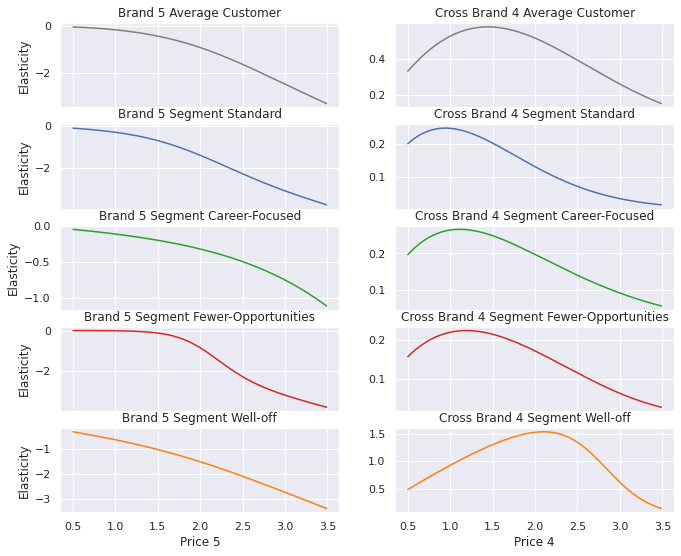

In [85]:
# We plot the own and cross brand price elasticities for the average customer and each of the four segments.
# We can observe differences and similiraties between the segments and examine their preference, when it comes to brand choice.
# The two segments, which seem to be of most interested for the marketing team of brand 5, seem to be the Career-focused
# and the Well-off. They are also the segments which purchase this brand most often. 
# The Career-focused segment is the most inelastic and they are the most loyal segment. 
# Based on our model, they do not seem to be that affected by price, therefore brand 5 could increase its price, 
# without fear of significant loss of customers from this segment. 
# The Well-off segment on the other hand, seems to be more elastic. They also purchase the competitor brand 4 most often.
# In order to target this segment, our analysis signals, that price needs to be decreased. However, keep in mind 
# that other factors aside from price might be influencing the purchase behaivour of this segment.
fig1, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 2, figsize = (11, 9), sharex = True)
ax1[0].plot(price_range, own_price_elasticity_brand_5, 'tab:grey')
ax1[0].set_title('Brand 5 Average Customer')
ax1[0].set_ylabel('Elasticity')
ax1[1].plot(price_range, brand5_cross_brand4_price_elasticity, 'tab:grey')
ax1[1].set_title('Cross Brand 4 Average Customer')


ax2[0].plot(price_range, own_price_elasticity_brand_5_s0)
ax2[0].set_title('Brand 5 Segment Standard')
ax2[0].set_ylabel('Elasticity')
ax2[1].plot(price_range, brand5_cross_brand4_price_elasticity_s0)
ax2[1].set_title('Cross Brand 4 Segment Standard')

ax3[0].plot(price_range, own_price_elasticity_brand_5_s1, 'tab:green')
ax3[0].set_title('Brand 5 Segment Career-Focused')
ax3[0].set_ylabel('Elasticity')
ax3[1].plot(price_range, brand5_cross_brand4_price_elasticity_s1, 'tab:green')
ax3[1].set_title('Cross Brand 4 Segment Career-Focused')

ax4[0].plot(price_range, own_price_elasticity_brand_5_s2, 'tab:red')
ax4[0].set_title('Brand 5 Segment Fewer-Opportunities')
ax4[0].set_ylabel('Elasticity')
ax4[1].plot(price_range, brand5_cross_brand4_price_elasticity_s2, 'tab:red')
ax4[1].set_title('Cross Brand 4 Segment Fewer-Opportunities')

ax5[0].plot(price_range, own_price_elasticity_brand_5_s3, 'tab:orange')
ax5[0].set_title('Brand 5 Segment Well-off')
ax5[0].set_xlabel('Price 5')
ax5[0].set_ylabel('Elasticity')
ax5[1].plot(price_range, brand5_cross_brand4_price_elasticity_s3, 'tab:orange')
ax5[1].set_title('Cross Brand 4 Segment Well-off')
ax5[1].set_xlabel('Price 4')